In [1]:
import time
start_time = time.time()

import pandas as pd
import numpy as np
np.random.seed(32)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

In [2]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")
nrow_test = test.shape[0]

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64


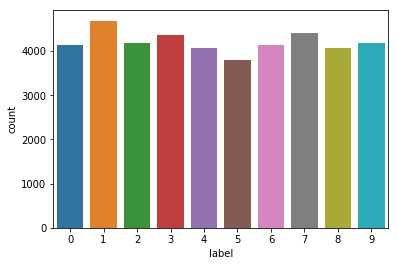

In [3]:
X_train = train.drop(labels = ["label"], axis = 1)
Y_train = train["label"]
print(Y_train.value_counts())
sns.countplot(Y_train)

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size = 0.3, random_state = 32)

In [5]:
from keras.utils.np_utils import to_categorical

X_train = X_train.values.reshape(-1, 28, 28, 1).astype("float32")/250
X_valid = X_valid.values.reshape(-1, 28, 28, 1).astype("float32")/250
Y_train = to_categorical(Y_train, num_classes = 10)
Y_valid = to_categorical(Y_valid, num_classes = 10)

Using TensorFlow backend.


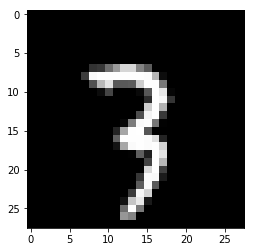

In [6]:
plt.imshow(X_train[0][:,:,0], cmap = plt.get_cmap("gray"))

In [7]:
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam, RMSprop
from keras.models import Model, load_model

def build_model():
    inp = Input(shape = [28, 28, 1])
    cnn_layer1 = Conv2D(filters = 32, kernel_size = (3, 3), padding = "same", activation = "relu")(inp)
    cnn_layer1 = Conv2D(filters = 32, kernel_size = (3, 3), padding = "same", activation = "relu")(cnn_layer1)
    cnn_layer1 = MaxPool2D(pool_size = (2, 2))(cnn_layer1)
    
    cnn_layer2 = Conv2D(filters = 64, kernel_size = (3, 3), padding = "same", activation = "relu")(cnn_layer1)
    cnn_layer2 = Conv2D(filters = 64, kernel_size = (3, 3), padding = "same", activation = "relu")(cnn_layer2)
    cnn_layer2 = MaxPool2D(pool_size = (2, 2))(cnn_layer2)
    
    out_put = Flatten()(cnn_layer2)
    out_put = Dense(256, activation = "relu")(out_put)
    out_put = Dense(10, activation = "softmax")(out_put)
    model = Model(inputs = inp, outputs = out_put)
    model.compile(loss = "categorical_crossentropy", optimizer = Adam(lr = 1e-3, decay = 0), metrics=["accuracy"])
    return model

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
__________

In [8]:
batch_size = 64
epochs = 15
# model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, verbose = 1, 
#           validation_data = (X_valid, Y_valid))

In [9]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint

file_path = "best_model.h5"
check_point = ModelCheckpoint(file_path, monitor = "val_acc", verbose = 1,
                              save_best_only = True, mode = "max")
early_stop = EarlyStopping(monitor = "val_acc", mode = "max", patience = 2)
datagen = ImageDataGenerator(featurewise_center = False,
                             samplewise_center = False,
                             featurewise_std_normalization = False,
                             samplewise_std_normalization = False,
                             zca_whitening = False,
                             rotation_range = 10,
                             zoom_range = 0.2,
                             width_shift_range = 0.15,
                             height_shift_range = 0.15,
                             horizontal_flip = False,
                             vertical_flip = False)
datagen.fit(X_train)
model.fit_generator(datagen.flow(X_train, Y_train, batch_size = batch_size), epochs = epochs, 
                   validation_data = (X_valid, Y_valid), callbacks = [check_point, early_stop])

Epoch 1/15
460/460 [==============================] - 170s 370ms/step - loss: 0.4152 - acc: 0.8678 - val_loss: 0.0755 - val_acc: 0.9776

Epoch 00001: val_acc improved from -inf to 0.97762, saving model to best_model.h5
Epoch 2/15
460/460 [==============================] - 168s 364ms/step - loss: 0.1251 - acc: 0.9619 - val_loss: 0.0548 - val_acc: 0.9829

Epoch 00002: val_acc improved from 0.97762 to 0.98286, saving model to best_model.h5
Epoch 3/15
460/460 [==============================] - 169s 368ms/step - loss: 0.0903 - acc: 0.9716 - val_loss: 0.0484 - val_acc: 0.9856

Epoch 00003: val_acc improved from 0.98286 to 0.98563, saving model to best_model.h5
Epoch 4/15
460/460 [==============================] - 172s 374ms/step - loss: 0.0736 - acc: 0.9776 - val_loss: 0.0330 - val_acc: 0.9898

Epoch 00004: val_acc improved from 0.98563 to 0.98984, saving model to best_model.h5
Epoch 5/15
460/460 [==============================] - 171s 373ms/step - loss: 0.0647 - acc: 0.9795 - val_loss: 0.04

In [10]:
model = load_model(file_path)
X_test = test.values.reshape(-1, 28, 28, 1).astype("float32")/250
prediction = model.predict(X_test, batch_size = 512, verbose = 1)
prediction = pd.DataFrame(np.argmax(prediction, axis = 1))
submission = pd.concat([pd.DataFrame(list(range(1, nrow_test+1))), prediction], axis = 1)
submission.columns = ["ImageId", "Label"]
submission.to_csv("submission.csv", index = False)
print("Completed, [{}]".format(time.time() - start_time))

28000/28000 [==============================] - 41s 1ms/step
Completed, [1578.2458939552307]


In [11]:
prediction.head()

,0
0,2
1,0
2,9
3,0
4,3
